In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\czope\AppData\Local\Temp\ipykernel_35744\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_data = session.query(func.max(Measurement.date)).scalar()
print(recent_data)

2017-08-23


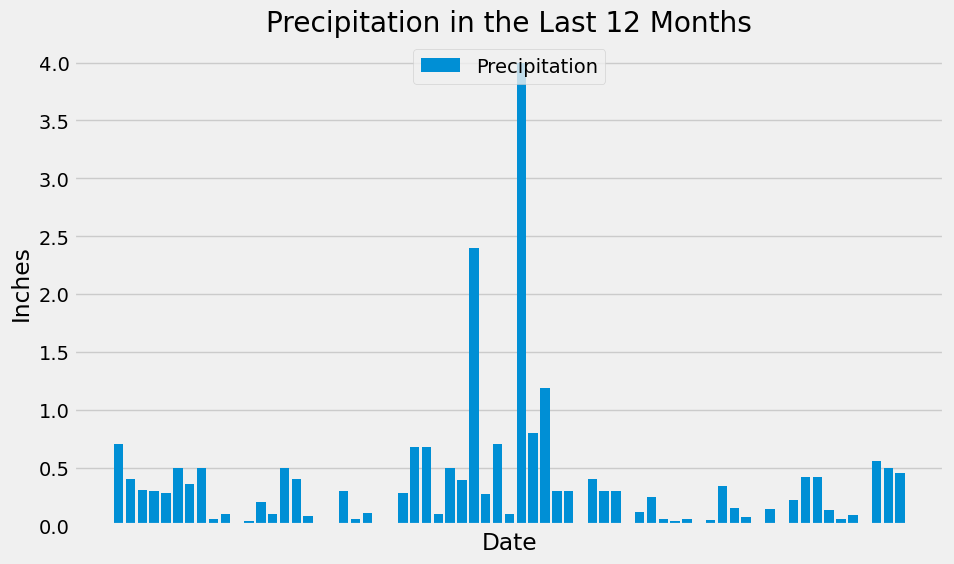

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = session.query(Measurement.date)\
                    .filter(Measurement.date <= recent_data)\
                    .order_by(Measurement.date.desc()).offset(365).first()

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                        .filter(Measurement.date >= one_year[0]).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel("Inches")
plt.title('Precipitation in the Last 12 Months')
plt.legend()
plt.xticks([])
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df['Precipitation'].describe()

count    330.000000
mean       0.106939
std        0.297390
min        0.000000
25%        0.000000
50%        0.020000
75%        0.100000
max        4.000000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).scalar()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                            .group_by(Measurement.station)\
                            .order_by(func.count(Measurement.station).desc())\
                            .all()
for station, count in most_active_stations:
    print(f"{station},{count}")

USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id= most_active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                            .filter(Measurement.station == most_active_id)\
                            .first()

# Unpack the results
lowest_temp = temperature_stats[0]
highest_temp = temperature_stats[1]
average_temp = temperature_stats[2]

# Print the calculated statistics
print(f"For the most active station (ID: {most_active_id}):")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

For the most active station (ID: USC00519281):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_stats = session.query(Measurement.tobs)\
                        .filter(Measurement.station == most_active_id)\
                        .filter(Measurement.date >= one_year)\
                        .all()

# Extract temperature values from the query results
temperatures = [temp[0] for temp in temperature_stats]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, label='Temperature Observations')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Last 12 Months')
plt.legend()
plt.show()

ProgrammingError: (sqlite3.ProgrammingError) Error binding parameter 2: type 'Row' is not supported
[SQL: SELECT measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?]
[parameters: ('USC00519281', ('2017-06-18',))]
(Background on this error at: https://sqlalche.me/e/20/f405)

# Close Session

In [ ]:
# Close Session
session.close()